In [1]:
from os import rename
from os.path import split, join
from glob import glob
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import product
from IPython.display import display, HTML
pd.options.display.max_columns = 8888
pd.options.display.max_rows = 8888
sns.set_context("paper")

In [2]:
dfs = []
for k, file in enumerate(glob(join("empirical_out", "*"))):
    df_tmp = pd.read_csv(file, header=None)
    dfs.append(df_tmp)

In [3]:
df = pd.concat(dfs)

In [4]:
df.shape

(36604, 25)

In [5]:
mean_names = ["EA", "EB", "EC"]
cov_names = ["VarA", "VarB", "VarC", "CovAB", "CovAC", "CovBC"]
param_names = ["shock_bw1_const", "output_bw1_coqnst_step1", "output_bw1_const_step2", "output_bw2_const"]
pretty_param_names = ["$c_{shock}$", "$c_{y,1}^{(1)}$", "$c_{y,1}^{(2)}$", "$c_{y,2}$"]

In [6]:
df.columns = ['n', 'kernel', 'output_bw1_const_step1', 'output_bw1_const_step2',  'output_bw2_const',
       'output_bw1_alpha', 'output_bw2_alpha', 'shock_bw1_const',
       'shock_bw2_const', 'shock_bw1_alpha', 'shock_bw2_alpha', 'mean_valid',
       'cov_valid',"time", 'name', 'value'] + mean_names + cov_names

In [7]:
group_cols = ['output_bw1_const_step1', 'output_bw1_const_step2',  'output_bw2_const',
       'output_bw1_alpha', 'output_bw2_alpha', 'shock_bw1_const',
       'shock_bw2_const', 'shock_bw1_alpha', 'shock_bw2_alpha']

In [8]:
df1 = df[(df["VarA"] > 0) & (df["VarB"] > 0)  & (df["VarC"] > 0) &
         (df["VarA"] < 40) & (np.abs(df["CovAB"]) < 20)  & (np.abs(df["CovAC"]) < 20) &
         (np.abs(df["CovAC"]) < np.sqrt(df["VarA"]*df["VarC"])) &
         (np.abs(df["CovAB"]) < np.sqrt(df["VarA"]*df["VarB"])) &
         (np.abs(df["CovBC"]) < np.sqrt(df["VarB"]*df["VarC"])) &
         (df["EA"] > 0) & (df["EB"] > 0)  & (df["EC"] < 10)
        ].drop_duplicates()

/Users/vitorh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [10]:
df1 = df1.reset_index(drop=True).reset_index()

In [11]:
df1

,level_0,index,n,kernel,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,mean_valid,cov_valid,time,name,value,EA,EB,EC,VarA,VarB,VarC,CovAB,CovAC,CovBC
0,0,0,10566,gaussian,1.0,0.1,0.1,0.1,0.1,5.0,20.0,0.166667,0.166667,2.0,2.0,0.5477,0.06114,252.005972,0.546145,0.005546,-0.005108,21.866274,0.279821,0.191146,-2.0175,0.217699,-0.13742


In [139]:
df[
  (df["output_bw1_const_step1"] == 5) &
  (df["output_bw1_const_step2"] == .1) &
  (df["output_bw2_const"] == 1) &
  (df["shock_bw1_const"] == 1) &
  (df["shock_bw2_const"] == 1) 
]

,n,kernel,output_bw1_const_step1,output_bw1_const_step2,output_bw2_const,output_bw1_alpha,output_bw2_alpha,shock_bw1_const,shock_bw2_const,shock_bw1_alpha,shock_bw2_alpha,mean_valid,cov_valid,time,name,value
0,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,EA,1.108333
1,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,EB,-0.014897
2,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,EC,-0.017416
3,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,VarA,442.560496
4,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,VarB,-0.652577
5,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,VarC,3.490814
6,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,CovAB,17.651112
7,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,CovAC,-46.377059
8,10566,neighbor,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.70689,0.061140,361.871488,CovBC,-0.500942
9,10566,gaussian,5.0,0.1,1.0,0.1,0.1,1.0,1.0,0.166667,0.166667,0.54770,0.093034,267.873707,EA,0.813063


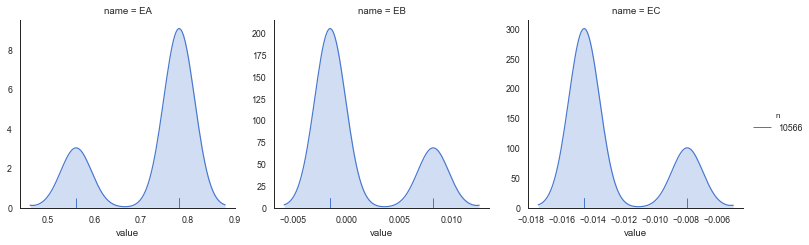

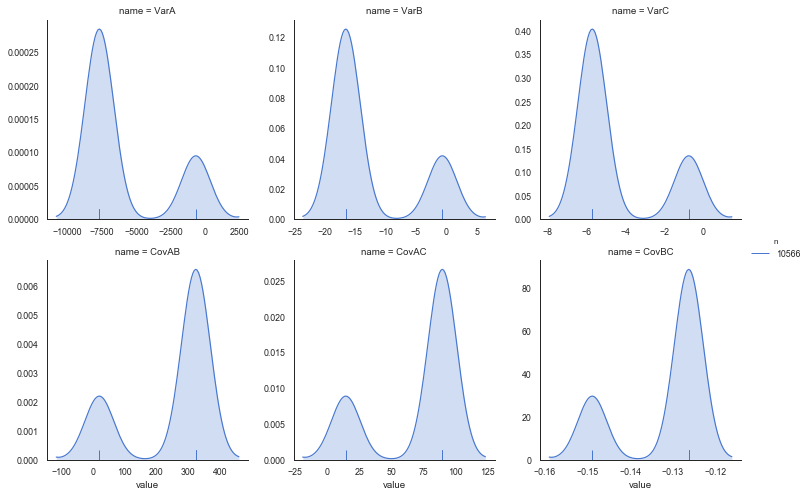

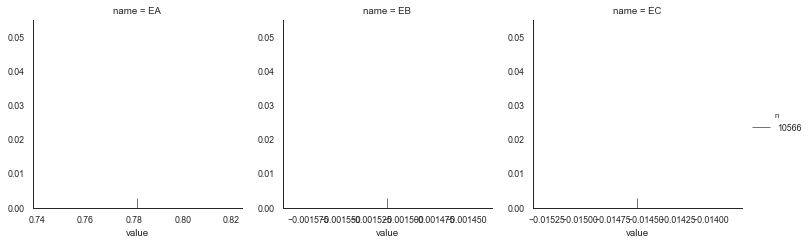

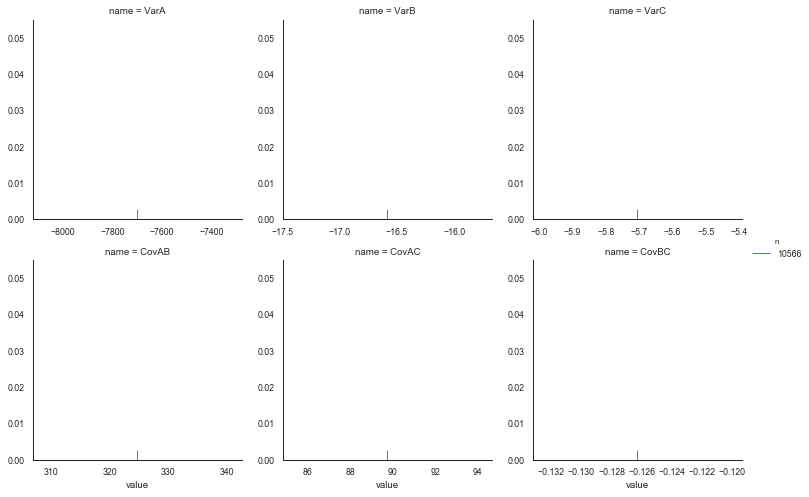

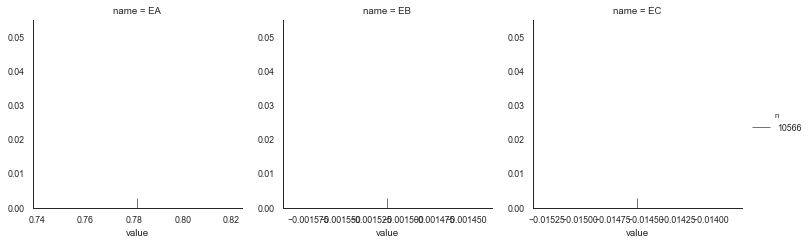

KeyboardInterrupt: 

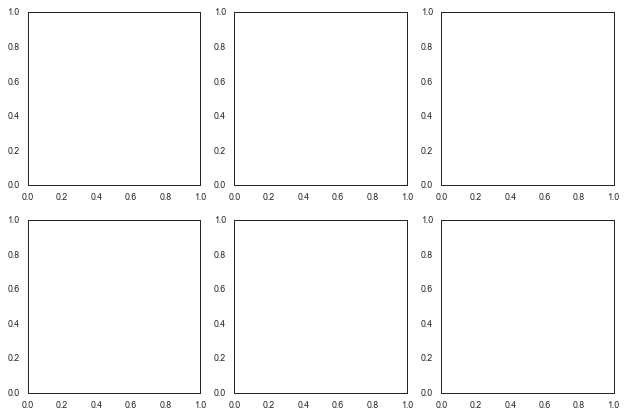

In [44]:
for param_values, df_grp in df.groupby(param_names):
    
    if float(Fraction(param_values[1])) < 0.1:
        continue

    title = "  ".join(f"{a, b}$ &nbsp;&nbsp;" for a,b in zip(pretty_param_names, param_values))
    display(HTML(f"<h2>{title}</h2>"))
    

    g = sns.FacetGrid(data=df_grp.query("name == @mean_names"), palette="muted",
                      hue="n",
                      col="name", sharey=False, sharex=False, height=3.5)
    g.map(sns.kdeplot, "value", shade=True)
    g.map(sns.rugplot, "value")
    g.add_legend()
    plt.show()

    g = sns.FacetGrid(data=df_grp.query("name == @cov_names"), 
                      hue="n", col="name", palette="muted",
                      sharey=False, sharex=False, height=3.5, col_wrap=3)
    g.map(sns.kdeplot, "value", shade=True)
    g.map(sns.rugplot, "value")
    g.add_legend()
    plt.show()


In [31]:
list(zip(pretty_param_names, param_values))

[('$c_{shock}$', 1),
 ('$c_{y,1}^{(1)}$', 1),
 ('$c_{y,1}^{(2)}$', 1),
 ('$c_{y,2}$', 5)]